## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Necessary Modules

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        

## Apply a distortion correction to raw images

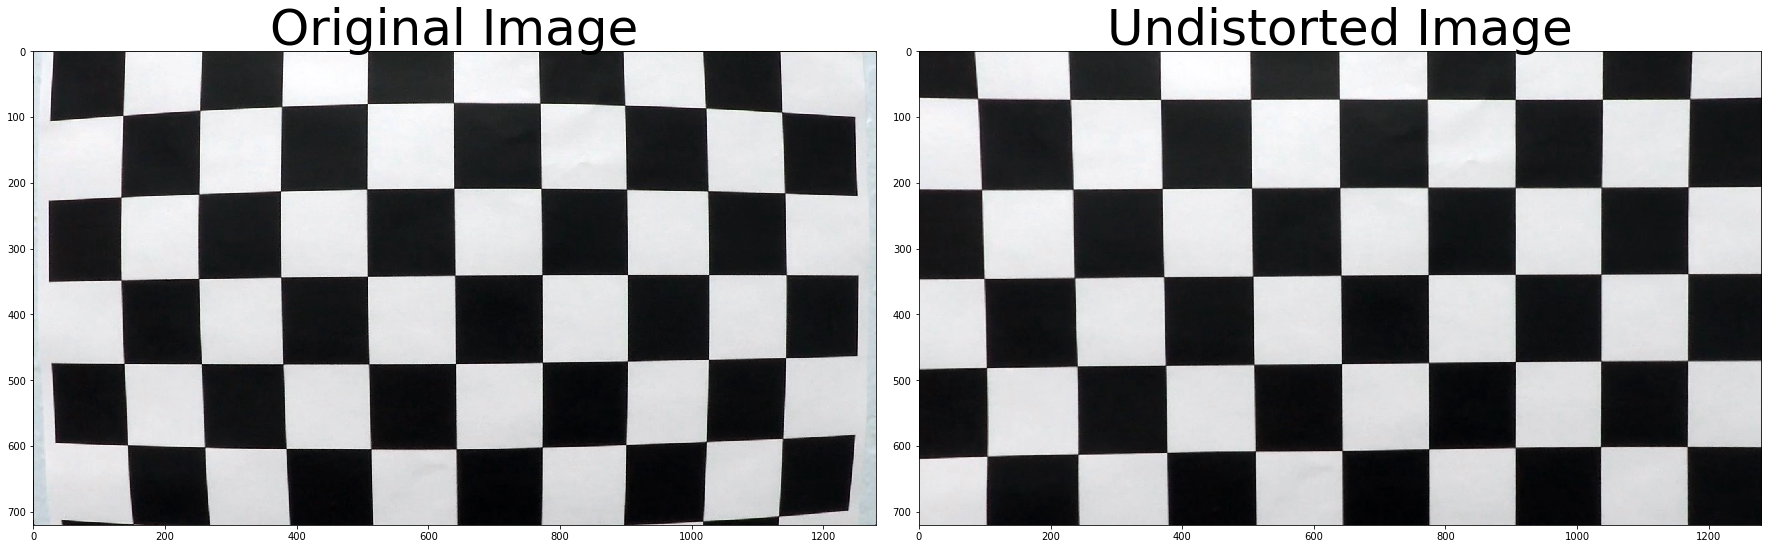

In [3]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image        
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img=cv2.imread('../camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image

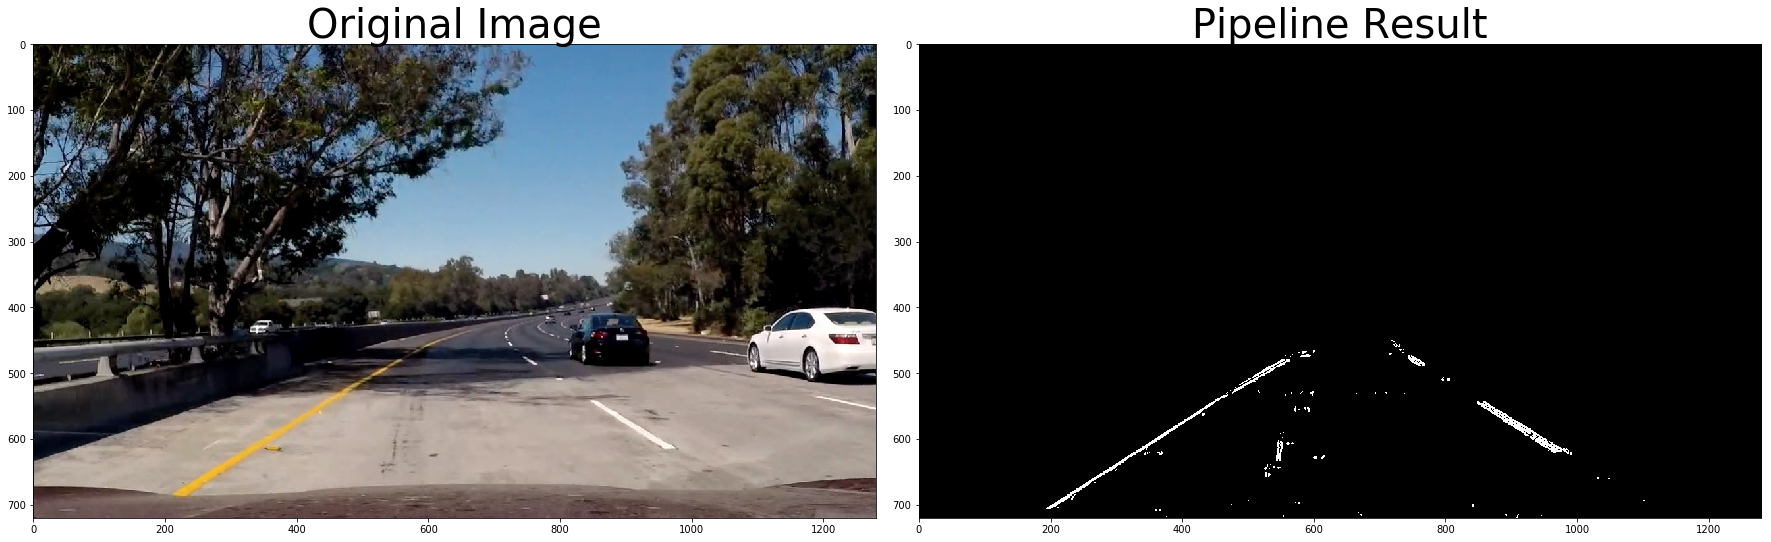

In [4]:
image = mpimg.imread('../test_images/test5.jpg')
img = cal_undistort(image, objpoints, imgpoints)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        print(ignore_mask_color)
    else:
        ignore_mask_color = 255
        
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def Canny(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    imshape = img.shape
    
    # Read in and grayscale the image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary),s_binary,sxbinary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # keeps the region of the image defined by the polygon
    vertices = np.array([[(170,imshape[0]),(imshape[1]/2 - 80, 470), 
                          (imshape[1]/2 + 80, 450), (imshape[1] - 100,imshape[0])]], dtype=np.int32)
    combined_binary=region_of_interest(combined_binary, vertices)

    return combined_binary
    
result = Canny(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

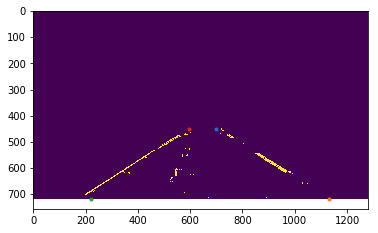

In [5]:
img = np.copy(result)
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)
plt.plot(700,450,'.') # top right
plt.plot(1130,720,'.') # bottom right
plt.plot(220,720,'.') # bottom left
plt.plot(595,450,'.') # top left


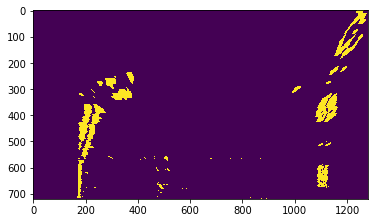

In [6]:
def warp(img):
    
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32([[700,450], [1130,720], [220,720], [595,450]])
    
    # Four desired coordinates
    dst = np.float32([[1100,0], [1100,720], [220,720], [220,0]])
    
    # Compute the pers
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    plt.imshow(warped)
    
    return warped

warped = warp(img)

## Detect lane pixels and fit to find the lane boundary

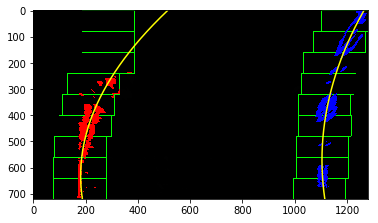

In [7]:
# Load our image
binary_warped = warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    global leftx
    global lefty
    global rightx
    global righty
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, leftx, lefty, rightx, righty
out_img, leftx, lefty, rightx, righty = fit_polynomial(binary_warped) 
plt.imshow(out_img)

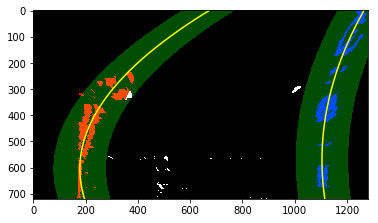

In [8]:
# Load our image - this should be a new frame since last time!
binary_warped = warped


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly_viz(binary_warped):
    global leftx
    global lefty
    global rightx
    global righty
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    
    if ((len(leftx) == 0) or (len(rightx) == 0) or (len(righty) == 0) or (len(lefty) == 0)):
        result, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
    
    else:
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ## 
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return result, leftx, rightx, lefty, righty
def search_around_poly(binary_warped):
    global leftx
    global lefty
    global rightx
    global righty
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    
    if ((len(leftx) == 0) or (len(rightx) == 0) or (len(righty) == 0) or (len(lefty) == 0)):
        result, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
    
    else:
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        
    return binary_warped, leftx, rightx, lefty, righty
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, leftx, rightx, lefty, righty = search_around_poly_viz(binary_warped)

# View your output
plt.imshow(result)

## Determine the curvature of the lane and vehicle position with respect to center

In [9]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power((1+np.square(2*left_fit[0]*y_eval+left_fit[1])),(3/2))/abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = np.power((1+np.square(2*right_fit[0]*y_eval+right_fit[1])),(3/2))/abs(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [10]:
# Calculate the radius of curvature in pixels for both lane lines
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

424.496037231 1052.30767272


In [11]:
def measure_curvature_real(ploty, leftx, rightx, lefty, righty):
     # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
 
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = np.power((1+np.square(2*left_fit[0]*y_eval*30/720+left_fit[1])), (3/2)) /abs(2*left_fit[0])
    right_curverad = np.power((1+np.square(2*right_fit[0]*y_eval*30/720+right_fit[1])), (3/2)) /abs(2*right_fit[0])
    
    return left_curverad, right_curverad


In [12]:
# Calculate the radius of curvature in meters for both lane lines
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_curverad, right_curverad = measure_curvature_real(ploty, leftx, rightx, lefty, righty)

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

122.051485673 m 335.247523393 m


## Warp the detected lane boundaries back onto the original image

In [13]:
def inverse_warp(img):
    
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32([[700,450], [1130,720], [220,720], [595,450]])
    
    # Four desired coordinates
    dst = np.float32([[1100,0], [1100,720], [220,720], [220,0]])
    
    # Compute the pers
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    inv_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return inv_warped

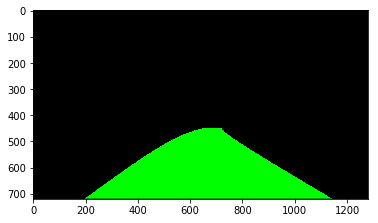

In [14]:
def draw(img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
   
    result = inverse_warp(color_warp)
    
    return result

newwarp = draw(warped)

plt.imshow(newwarp)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

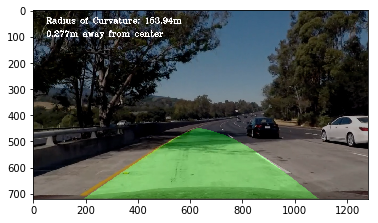

In [19]:
frame = mpimg.imread('../test_images/test5.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)

def pipeline(frame):
    image = cal_undistort(frame, objpoints, imgpoints)

    #Disabled, techinically each frame needs to be undistored before being processed.
    #objpoints, imgpoints = [] #Add them manually
    
    frame = Canny(image, s_thresh=(170, 255), sx_thresh=(20, 100))
    frame = warp(frame)
    frame, leftx, rightx, lefty, righty = search_around_poly(frame)
    left_curverad, right_curverad = measure_curvature_real(ploty, leftx, rightx, lefty, righty)
    frame = draw(frame)
    frame = cv2.addWeighted(frame, 0.3, image, 0.7, 0)
    
    curvature = (left_curverad + right_curverad) / 2
    car_pos = image.shape[1] / 2
    center = (abs(car_pos - curvature)*(3.7/650))/10
    curvature = 'Radius of Curvature: ' + str(round(curvature, 2)) + 'm'
    center = str(round(center, 3)) + 'm away from center'
    frame = cv2.putText(frame, curvature, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    frame = cv2.putText(frame, center, (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    plt.imshow(frame)
    
    return frame

frame = pipeline(frame)
plt.imshow(frame)

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = '../test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video ../test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 1260/1261 [26:49<00:01,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/solidWhiteRight.mp4 

CPU times: user 24min 18s, sys: 27.1 s, total: 24min 45s
Wall time: 26min 51s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))